In [2]:
# Conv.py takes input number of filters and its function forward takes the image array as input and 
# overall returns 3d array with filters applied,
# input : 8   28*28 array
# Output: 26*26*8 array
import os
os.system('pip install mnist')
import numpy as np
class conv3x3:
    def __init__(self,num_filters):
        self.num_filters=num_filters
        self.filters=np.random.rand(num_filters,3,3)

    def iterate_regions(self,image):
        d1,d2=image.shape
        for i in range(d1-2):
            for j in range(d2-2):
                region=image[i:(i+3),j:(j+3)]
                yield region,i,j

    def forward(self,input):
        d1,d2=input.shape
        self.last_input=input
        output=np.zeros((d1-2,d2-2,self.num_filters))
        for region,i,j in self.iterate_regions(input):
            output[i,j]=np.sum(region*self.filters,axis=(1,2))
        return output
    
    def backprop(self, d_L_d_out, learn_rate):

        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        return None

In [3]:
#Maxpool's function forward takes 26*26*8 input and do maxpool and return 13*13*8 array.
import numpy as np
class max_pool:
    def iterate_regions(self,image):
        d1,d2,d3=image.shape
        for i in range(d1//2):
            for j in range(d2//2):
                region=image[2*i:2*(i+1),2*j:2*(j+1)]
                yield region,i,j
    def forward(self,input):
        d1,d2,d3=input.shape
        self.last_input = input
        output=np.zeros((d1//2,d2//2,d3))
        for region,i,j in self.iterate_regions(input):
            output[i,j]=np.max(region,axis=(0,1))
        return output
    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

        for i2 in range(h):
            for j2 in range(w):
                for f2 in range(f):
                    # If this pixel was the max value, copy the gradient to it.
                    if im_region[i2, j2, f2] == amax[f2]:
                        d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [4]:
# This class soft_max takes input of (number of elements in new maxpooled img "13*13*8=1352") 
# and (number of nodes 10) and forward function takes input of the img array
# and returns a array 10 with probablities for each one.
import numpy as np
class soft_max:
    def __init__(self,input_len,num_nodes):
        self.weights=np.random.randn(input_len,num_nodes)/input_len
        self.biases=np.zeros(num_nodes)
    def forward(self,input):
        self.last_input_shape = input.shape
        input=input.flatten()
        self.last_input = input
        #calculaing wX+b
        totals=np.dot(input,self.weights)+self.biases
        self.last_totals=totals
        #final output
        expx=np.exp(totals)
        output=expx/np.sum(expx,axis=0)
        return output
    def backprop(self,d_L_d_out,learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b
            return d_L_d_inputs.reshape(self.last_input_shape)


In [5]:
import mnist
import numpy as np

conv=conv3x3(8)
pool=max_pool()
Softmax=soft_max(13*13*8,10)

train_images=mnist.train_images()[:10000]
train_labels=mnist.train_labels()[:10000]
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

def forward(image,label):
    output=conv.forward((image/255)-0.5)
    output=pool.forward(output)
    output=Softmax.forward(output)

    loss=-np.log(output[label])
    accuracy=1 if np.argmax(output)==label else 0

    return output, loss, accuracy

def train(im, label, lr=.005):
        # Forward
    out, loss, acc = forward(im, label)

    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    # Backprop
    gradient = soft_max.backprop(Softmax,gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc


print('CNN initialised')

# Training the CNN for 3 epochs
for epoch in range(3):
    print('--- Epoch %d ---' % (epoch + 1))


    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]

    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i > 0 and i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc


print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

CNN initialised
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 10.824 | Accuracy: 28%
[Step 200] Past 100 steps: Average Loss 6.215 | Accuracy: 51%
[Step 300] Past 100 steps: Average Loss 5.401 | Accuracy: 59%
[Step 400] Past 100 steps: Average Loss 4.722 | Accuracy: 62%
[Step 500] Past 100 steps: Average Loss 3.966 | Accuracy: 66%
[Step 600] Past 100 steps: Average Loss 4.556 | Accuracy: 68%
[Step 700] Past 100 steps: Average Loss 4.575 | Accuracy: 66%
[Step 800] Past 100 steps: Average Loss 3.140 | Accuracy: 72%
[Step 900] Past 100 steps: Average Loss 3.091 | Accuracy: 75%
[Step 1000] Past 100 steps: Average Loss 3.236 | Accuracy: 78%
[Step 1100] Past 100 steps: Average Loss 3.638 | Accuracy: 74%
[Step 1200] Past 100 steps: Average Loss 2.873 | Accuracy: 75%
[Step 1300] Past 100 steps: Average Loss 3.004 | Accuracy: 76%
[Step 1400] Past 100 steps: Average Loss 3.670 | Accuracy: 69%
[Step 1500] Past 100 steps: Average Loss 2.332 | Accuracy: 78%
[Step 1600] Past 100 steps: Ave

[Step 3100] Past 100 steps: Average Loss 2.010 | Accuracy: 80%
[Step 3200] Past 100 steps: Average Loss 1.566 | Accuracy: 77%
[Step 3300] Past 100 steps: Average Loss 0.924 | Accuracy: 90%
[Step 3400] Past 100 steps: Average Loss 0.758 | Accuracy: 90%
[Step 3500] Past 100 steps: Average Loss 2.031 | Accuracy: 81%
[Step 3600] Past 100 steps: Average Loss 1.070 | Accuracy: 86%
[Step 3700] Past 100 steps: Average Loss 0.560 | Accuracy: 92%
[Step 3800] Past 100 steps: Average Loss 1.595 | Accuracy: 80%
[Step 3900] Past 100 steps: Average Loss 0.793 | Accuracy: 87%
[Step 4000] Past 100 steps: Average Loss 1.517 | Accuracy: 85%
[Step 4100] Past 100 steps: Average Loss 0.716 | Accuracy: 90%
[Step 4200] Past 100 steps: Average Loss 1.326 | Accuracy: 85%
[Step 4300] Past 100 steps: Average Loss 0.633 | Accuracy: 91%
[Step 4400] Past 100 steps: Average Loss 1.085 | Accuracy: 87%
[Step 4500] Past 100 steps: Average Loss 1.230 | Accuracy: 83%
[Step 4600] Past 100 steps: Average Loss 0.906 | Accura

[Step 6100] Past 100 steps: Average Loss 0.494 | Accuracy: 92%
[Step 6200] Past 100 steps: Average Loss 0.852 | Accuracy: 85%
[Step 6300] Past 100 steps: Average Loss 0.339 | Accuracy: 93%
[Step 6400] Past 100 steps: Average Loss 0.536 | Accuracy: 90%
[Step 6500] Past 100 steps: Average Loss 0.566 | Accuracy: 85%
[Step 6600] Past 100 steps: Average Loss 0.835 | Accuracy: 86%
[Step 6700] Past 100 steps: Average Loss 0.429 | Accuracy: 91%
[Step 6800] Past 100 steps: Average Loss 0.575 | Accuracy: 88%
[Step 6900] Past 100 steps: Average Loss 0.532 | Accuracy: 90%
[Step 7000] Past 100 steps: Average Loss 0.724 | Accuracy: 84%
[Step 7100] Past 100 steps: Average Loss 0.395 | Accuracy: 90%
[Step 7200] Past 100 steps: Average Loss 0.310 | Accuracy: 92%
[Step 7300] Past 100 steps: Average Loss 0.802 | Accuracy: 88%
[Step 7400] Past 100 steps: Average Loss 1.035 | Accuracy: 84%
[Step 7500] Past 100 steps: Average Loss 0.403 | Accuracy: 88%
[Step 7600] Past 100 steps: Average Loss 0.505 | Accura

## Now Using Keras

In [6]:
import numpy as np
import mnist
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images=mnist.test_images()
test_labels=mnist.test_labels()

#Normalising the images
test_images=(test_images/255)-0.5
train_images=(train_images/255)-0.5

#Reshaping the each images from 28*28 to 28*28*1
#expand_dims converts axis 3 [0,0,0...] to [[0],[0],[0]...]
train_images=np.expand_dims(train_images,axis=3)
test_images=np.expand_dims(test_images,axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

###1: Building model

#we choose Sequential model
#Conv2D > 28*28 to 26*26*8
#Maxpooling > 26*26*8 to 13*13*8
#flatten + Softmax as activation function > 13*13*8 to 1352 to 10
model=Sequential([
    Conv2D(num_filters,filter_size,input_shape=(28,28,1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10, activation="softmax"),
])

###2: configuring training process

#optimizer: adam based
#loss function: c_c
#metrics: what we want*
model.compile(
    'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

###3: Training model

# *we need[0,0,0,4,0,0,0,0,0,0] instead of [4] from labels
model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=10,
    validation_data=(test_images, to_categorical(test_labels)),
)

### 4: Saving weights

model.save_weights('cnn.h5')

predictions = model.predict(test_images[:5])
print(np.argmax(predictions, axis=1))
print(test_labels[:5])

Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.5838 - accuracy: 0.8300 - val_loss: 0.2149 - val_accuracy: 0.9391
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1939 - accuracy: 0.9451 - val_loss: 0.1337 - val_accuracy: 0.9611
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1260 - accuracy: 0.9643 - val_loss: 0.1010 - val_accuracy: 0.9694
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0940 - accuracy: 0.9724 - val_loss: 0.0889 - val_accuracy: 0.9712
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0828 - accuracy: 0.9769 - val_loss: 0.0820 - val_accuracy: 0.9739
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0725 - accuracy: 0.9790 - val_loss: 0.0770 - val_accuracy: 0.9746
Epoch 7/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.0609 - accuracy: 0.9823 - val_loss: 0.0745 -

# Separation

total_acuracy= 97.27 %
1 





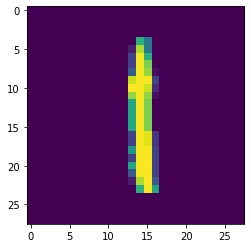

1 





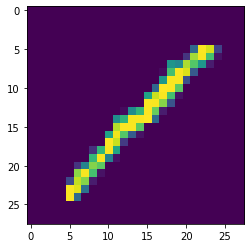

0 





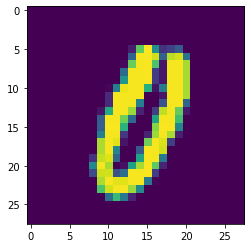

2 





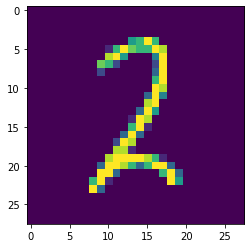

8 





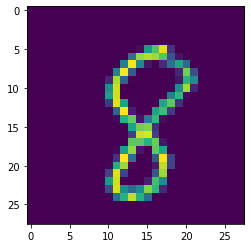

1 





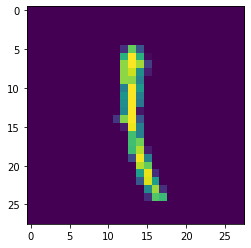

6 





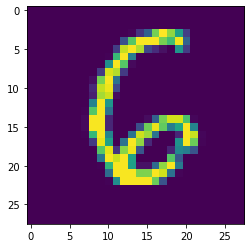

2 





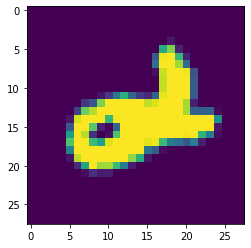

8 





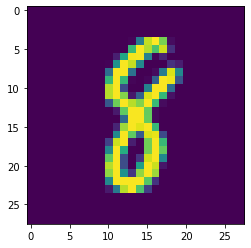

7 





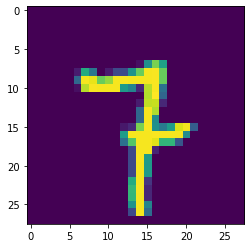

2 





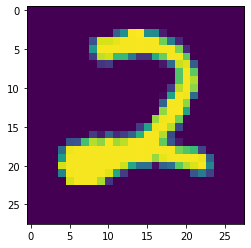

3 





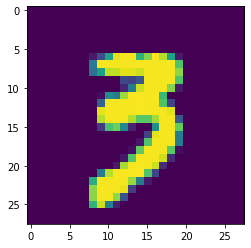

2 





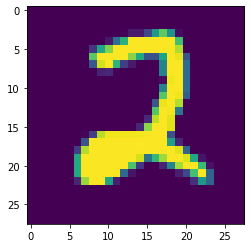

7 





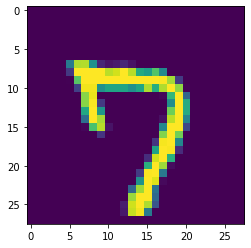

0 





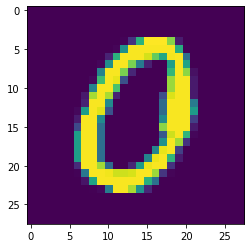

8 





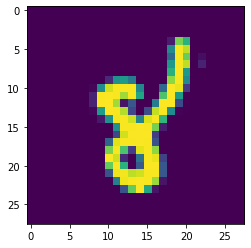

2 





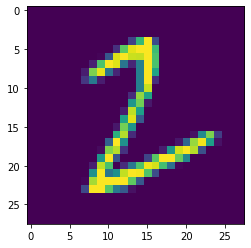

7 





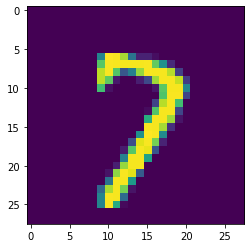

4 





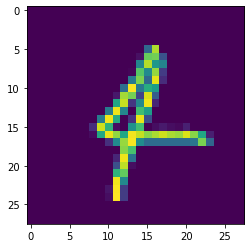

3 





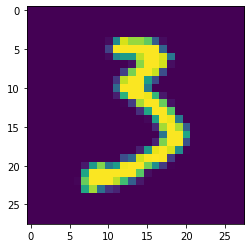

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import mnist

###***
test_images=mnist.test_images()
test_images=np.expand_dims((test_images/255)-0.5,axis=3)
test_labels=mnist.test_labels()

### we skipped part 3 as we exported the weights

num_filters=8
filter_size=3
pool_size=2

model=Sequential([
    Conv2D(num_filters,filter_size,input_shape=(28,28,1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10,activation='softmax'),
])

n=10000
model.load_weights('cnn.h5')
prediction = model.predict(test_images[:n])
max_pred=np.argmax(prediction,axis=1)

DIFF=(max_pred)-test_labels[:n]
win=len(DIFF[DIFF==0])
print("total_acuracy=",(100*win)/n,"%")

for i in np.random.randint(1,6000,20):
    plt.imshow(test_images[i])
    print(np.argmax(prediction,axis=1)[i],"\n\n\n")
    plt.show()